In [182]:
# can be a good idea to analyze by day of week 
# use sns
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns


order_num = pd.read_csv('order_num.csv')
monthly = pd.read_csv('monthly_deliver.csv') 
weekly = pd.read_csv('weekly_delivery.csv')
avg_revenue = pd.read_csv('avg_revenue_by_order_num.csv')
weekly_retention = pd.read_csv('weekly_retention.csv')
weekly_sale = pd.read_csv('weekly_sales.csv')
weekly_profit = pd.read_csv('weekly_profit.csv')

### Weekly sales graph
#### SQL code to get the weekly_sale data
```sql
SELECT 
    DATE_TRUNC('week',o.order_date) as week,
    SUM(m.meal_price * o.order_quantity) as revenue
FROM meals as m 
JOIN orders as o
ON m.meal_id = o.meal_id
GROUP BY week
ORDER BY week ASC;


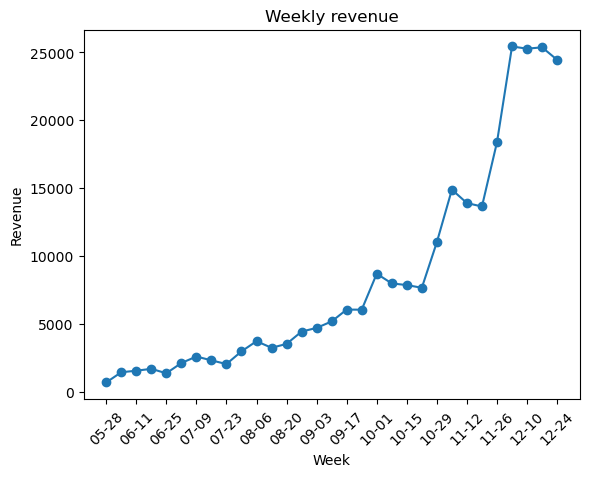

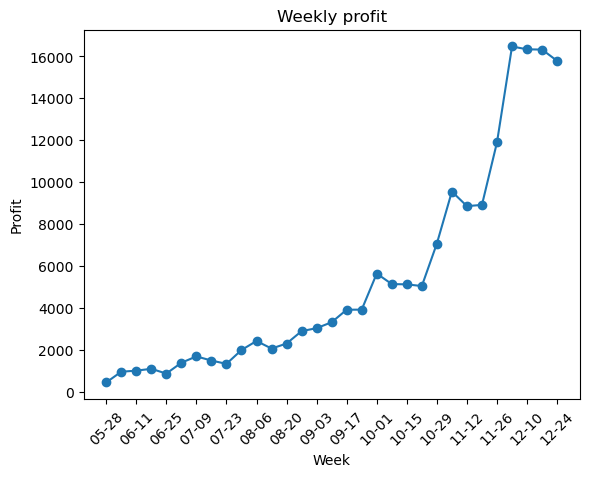

In [183]:
weekly_sale['week'] = pd.to_datetime(weekly_sale['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly_sale['week'] = weekly_sale['week'].dt.strftime('%m-%d')

weekly_profit['week'] = pd.to_datetime(weekly_profit['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly_profit['week'] = weekly_profit['week'].dt.strftime('%m-%d')
weekly_profit = weekly_profit.sort_values('week', ascending=True).reset_index(drop=True)

plt.plot(weekly_sale['week'],weekly_sale['revenue'],marker='o')
plt.xlabel('Week')
plt.ylabel('Revenue')
plt.title('Weekly revenue')
plt.xticks(ticks = range(0, len(weekly_sale['week']),2),rotation=45)
plt.show()

plt.plot(weekly_profit['week'],weekly_profit['profit'],marker='o')
plt.xlabel('Week')
plt.ylabel('Profit')
plt.title('Weekly profit')
plt.xticks(ticks = range(0, len(weekly_profit['week']),2),rotation=45)
plt.show()

Since the app was released, sales have increased week after week.

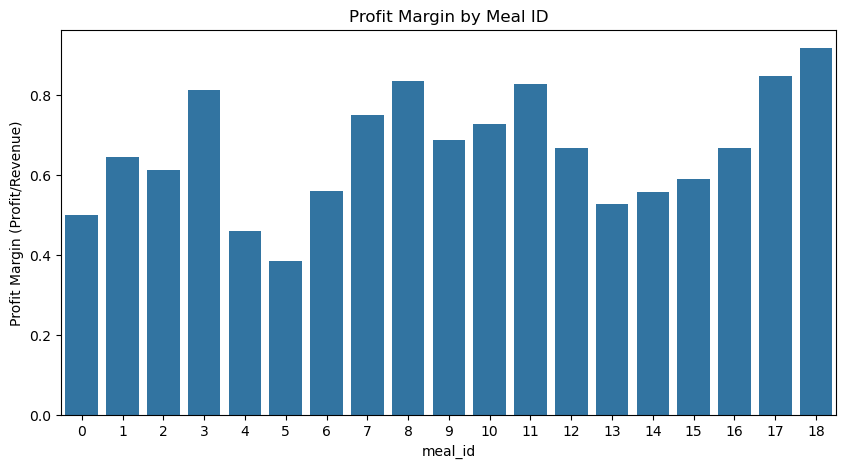

In [188]:
profit = pd.read_csv('profit_items.csv')
profit['profit_margin'] = profit['profit'] / df['revenue']
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(x='meal_id', y='profit_margin', data=df)
ax.set_title('Profit Margin by Meal ID')
ax.set_ylabel('Profit Margin (Profit/Revenue)')
plt.show()

### SQL code to get the order_num data
```sql
WITH order_count as (
    select 
        o.user_id,
        COUNT(distinct o.order_id ) as orders,
        avg(m.meal_price * o.order_quantity) as revenue 
    from orders as o
    join meals as m 
    on m.meal_id = o.meal_id
    group by o.user_id
)
select 
    orders,
    avg(revenue) as avg_revenue
from order_count
group by orders
ORDER BY orders;

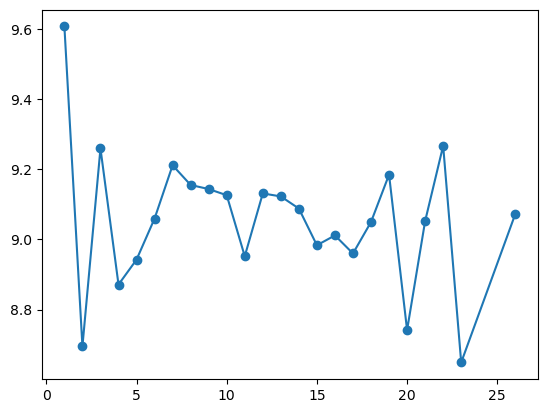

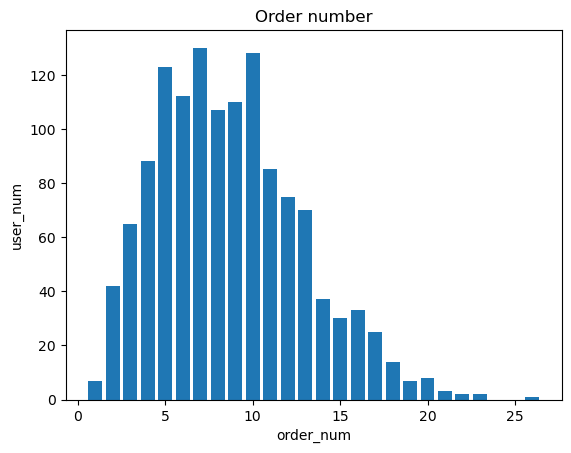

In [184]:
#orders
plt.plot(avg_revenue['orders'], avg_revenue['avg_revenue'],marker ='o')
plt.show()


plt.bar(order_num['orders'], order_num['users'])
plt.xlabel('order_num')
plt.ylabel('user_num')
plt.title('Order number')
plt.show()

### SQL code to get the weekly_retention data
```sql
WITH user_weekly_activity AS (
  SELECT DISTINCT
    DATE_TRUNC('week', order_date) :: DATE AS week,
    user_id
  FROM orders)

SELECT
  previous.week,
  ROUND(
    COUNT(distinct current.user_id) :: numeric /
    GREATEST(COUNT(DISTINCT previous.user_id), 1), -- avoid dividing by 0 
  2) AS retention_rate
FROM user_weekly_activity AS previous
LEFT JOIN user_weekly_activity AS current
ON current.user_id = previous.user_id
AND previous.week = (current.week -INTERVAL'1 week')
GROUP BY previous.week
ORDER BY previous.week ASC;

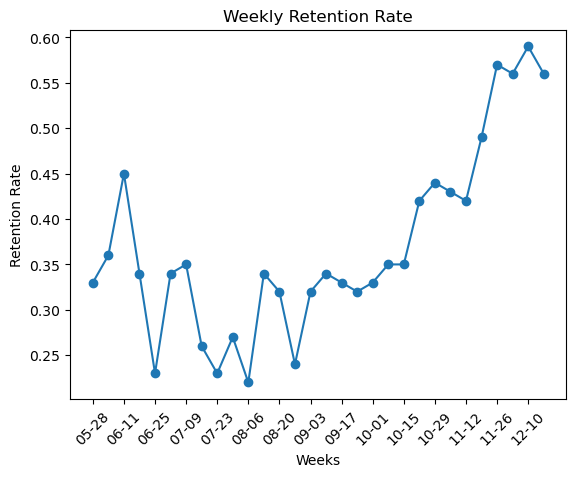

In [185]:
# retention rate 
weekly_retention['week'] = pd.to_datetime(weekly_retention['week'], format='%Y-%m-%d', utc=True)
weekly_retention = weekly_retention[weekly_retention['week'] != '2018-12-24']
weekly_retention['week'] = weekly_retention['week'].dt.strftime('%m-%d')

plt.plot(weekly_retention['week'],weekly_retention['retention_rate'],marker ='o')
plt.xlabel('Weeks')
plt.ylabel('Retention Rate')
plt.title('Weekly Retention Rate')
plt.xticks(ticks = range(0, len(weekly_retention['week']),2), rotation =45)
plt.show()

### SQL code to get the monthly data
```sql
WITH arpu as(
    SELECT 
        DATE_TRUNC('month',order_date) as month,
        SUM(m.meal_price * o.order_quantity) as total_revenue,
        COUNT(DISTINCT o.user_id) as total_users,
        ROUND(
            SUM(m.meal_price * o.order_quantity) :: numeric / COUNT(DISTINCT o.user_id)
            ,2) as ARPU
    FROM meals as m  
    JOIN orders as o 
    ON m.meal_id = o.meal_id
    group BY DATE_TRUNC('month',o.order_date)
)
SELECT 
    month,
    ARPU
FROM arpu
ORDER BY month;

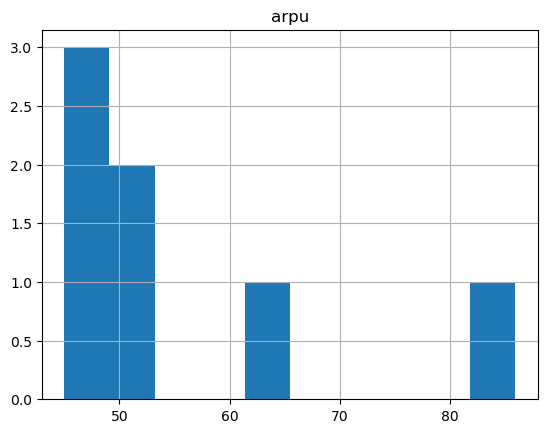

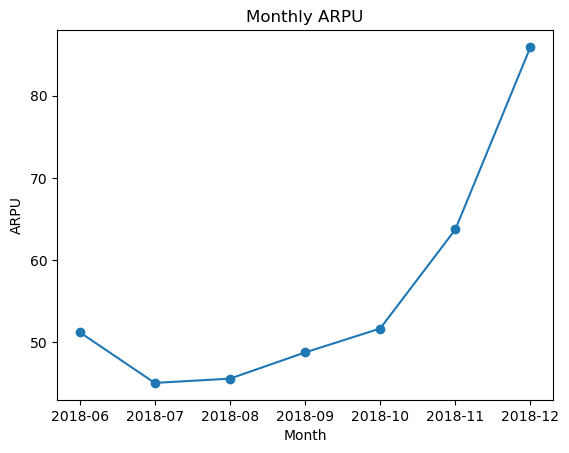

In [186]:

# extract only year and month from 'month' column
monthly['month'] = pd.to_datetime(monthly['month'],utc=True)
monthly['month'] = monthly['month'].dt.strftime('%Y-%m')

# plot histgram
monthly.hist()
plt.show()

#plot linechart
plt.plot(monthly['month'], monthly['arpu'], marker='o')
plt.xlabel('Month')
plt.ylabel('ARPU')
plt.title('Monthly ARPU')

plt.show()

Despite dropping ARPU rates after the release of the app, the growth rate has accelerated since October 2018 and continues to grow.

### SQL code to get the weekly data
```sql
WITH arpu as(
    SELECT 
        DATE_TRUNC('week',order_date) as week,
        SUM(m.meal_price * o.order_quantity) as total_revenue,
        COUNT(DISTINCT o.user_id) as total_users,
        ROUND(
            SUM(m.meal_price * o.order_quantity) :: numeric / COUNT(DISTINCT o.user_id)
            ,2) as ARPU
    FROM meals as m  
    JOIN orders as o 
    ON m.meal_id = o.meal_id
    group BY DATE_TRUNC('week',o.order_date)
)
SELECT 
    week,
    ARPU
FROM arpu
ORDER BY week;

Weekly ARPU 

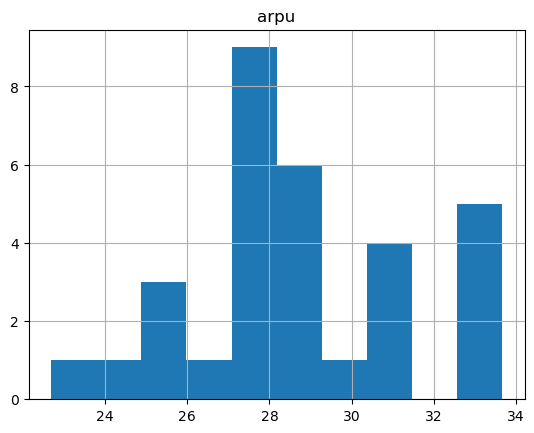

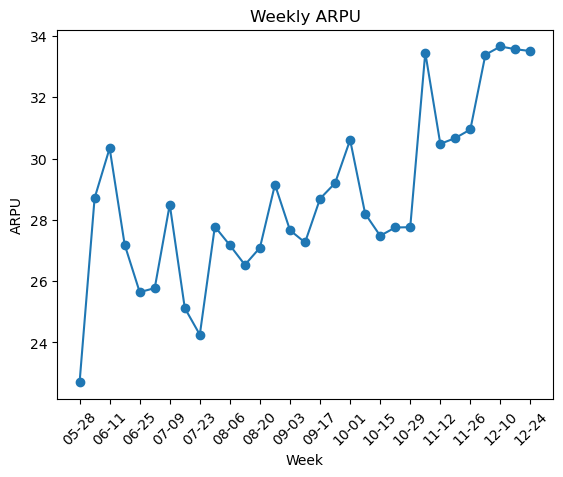

In [187]:
weekly['week'] = pd.to_datetime(weekly['week'], format='%Y-%m-%d %H:%M:%S%z', utc=True)
weekly['week'] = weekly['week'].dt.strftime('%m-%d')

# plot histgram
weekly.hist()
plt.show()

# plot linechart 
plt.plot(weekly['week'], weekly['arpu'], marker='o')
plt.xlabel('Week')
plt.ylabel('ARPU')
plt.title('Weekly ARPU')
plt.xticks(ticks = range(0, len(weekly['week']),2),rotation=45)
plt.show()

Although ARPU generally increases over time, the trend isn't constant, with a sharp increase from late October to November, and noticeable decreases in mid-June, July and September. Further analysis is needed to determine whether these fluctuations are seasonal or influenced by other factors.